# iMeta classification algorithm demo
The work of the XBT project builds on previous work to create an algorithm to fill in missing metadata relating to probe type and manufacturer in the XBt dataset. This algorithm is called the iMeta algorithm and is decribed in this paper:
https://journals.ametsoc.org/doi/full/10.1175/JTECH-D-17-0129.1

It is a deterministic algorithm which uses the country, maximum depth of profile and date of profile as input. The frequency of probe types by date was studied and the assignment of probe model and manufacturer using the three input values is based on the changes in the frequency of observed types over time to determine the most likely model and manufacturer.

This flow chart describes the algorithm, which has been implemented in the code used by this notebook.

<img src="https://drive.google.com/uc?export=view&id=1LsuvnD0HbpG1W5AIqJcHi8qhY5TEBTx2" width="600" height="600" align="left">



In [1]:
import os
import sys
from pathlib import Path

import pandas
import numpy
import sklearn
import sklearn.metrics
import matplotlib
import matplotlib.pyplot

In [2]:
root_repo_dir = Path().absolute().parent
sys.path = [str(root_repo_dir)] + sys.path

In [3]:
from xbt.dataset import XbtDataset
from xbt.imeta import imeta_classification, XBT_MAX_DEPTH

In [5]:
# TODO: access through a intake catalog
# Set up some site specific parameters for the notebook
try:
    environment = os.environ['XBT_ENV_NAME']
except KeyError:
    environment = 'pangeo'
env_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/csv_with_imeta',
    'pangeo': '/data/misc/xbt-data/csv_with_imeta/',
}
env_date_ranges = {
    'MO_scitools': (1966,2015),
    'pangeo': (1966,2015)
}
result_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/results',
    'pangeo': '/data/misc/xbt-data/results/',   
}


In [6]:
# Set up some dataset specific parameters
xbt_data_dir = env_data_dirs[environment]
DATA_YEAR_RANGE=env_date_ranges[environment]
columns = ['year','num obs ''num cruises', 'unknown brand or type',
           'unknown type', 'num_instruments','num_platforms']
result_dir = result_dirs[environment]

In [7]:
xbt_full_dataset = XbtDataset(xbt_data_dir, env_date_ranges[environment])

In [8]:
xbt_labelled = xbt_full_dataset.filter_obs({'labelled': 'labelled'})


In [9]:
imeta_classes = xbt_labelled.xbt_df.apply(imeta_classification, axis=1)
imeta_model = imeta_classes.apply(lambda t1: t1[0])
imeta_manufacturer = imeta_classes.apply(lambda t1: t1[1])


In [10]:
imeta_instrument = imeta_classes.apply(lambda t1: f'XBT: {t1[0]} ({t1[1]})') 

In [11]:
actual_classes = xbt_labelled.xbt_df.apply(lambda row1: (row1['model'],row1['manufacturer']), axis=1)

### Maximum depth of profiles for different probe types
These plots show the max depth of profiles for different probe types, which is used by the iMeta algorithm.


In [12]:
instruments_to_plot = [
   'XBT: T4 (SIPPICAN)',
   'XBT: T5 (SIPPICAN)',
   'XBT: T7 (SIPPICAN)',
   'XBT: T10 (SIPPICAN)',
   'XBT: DEEP BLUE (SIPPICAN)',
   'XBT: FAST DEEP (SIPPICAN)',
   'XBT: T4 (TSK - TSURUMI SEIKI Co.)',
   'XBT: T5 (TSK - TSURUMI SEIKI Co.)',
   'XBT: T6 (TSK - TSURUMI SEIKI Co.)',    
   'XBT: T7 (TSK - TSURUMI SEIKI Co.)',
   'XBT: T10 (TSK - TSURUMI SEIKI Co.)',
]
depth_bins = list(map(float, list(range(0,2001,50))))

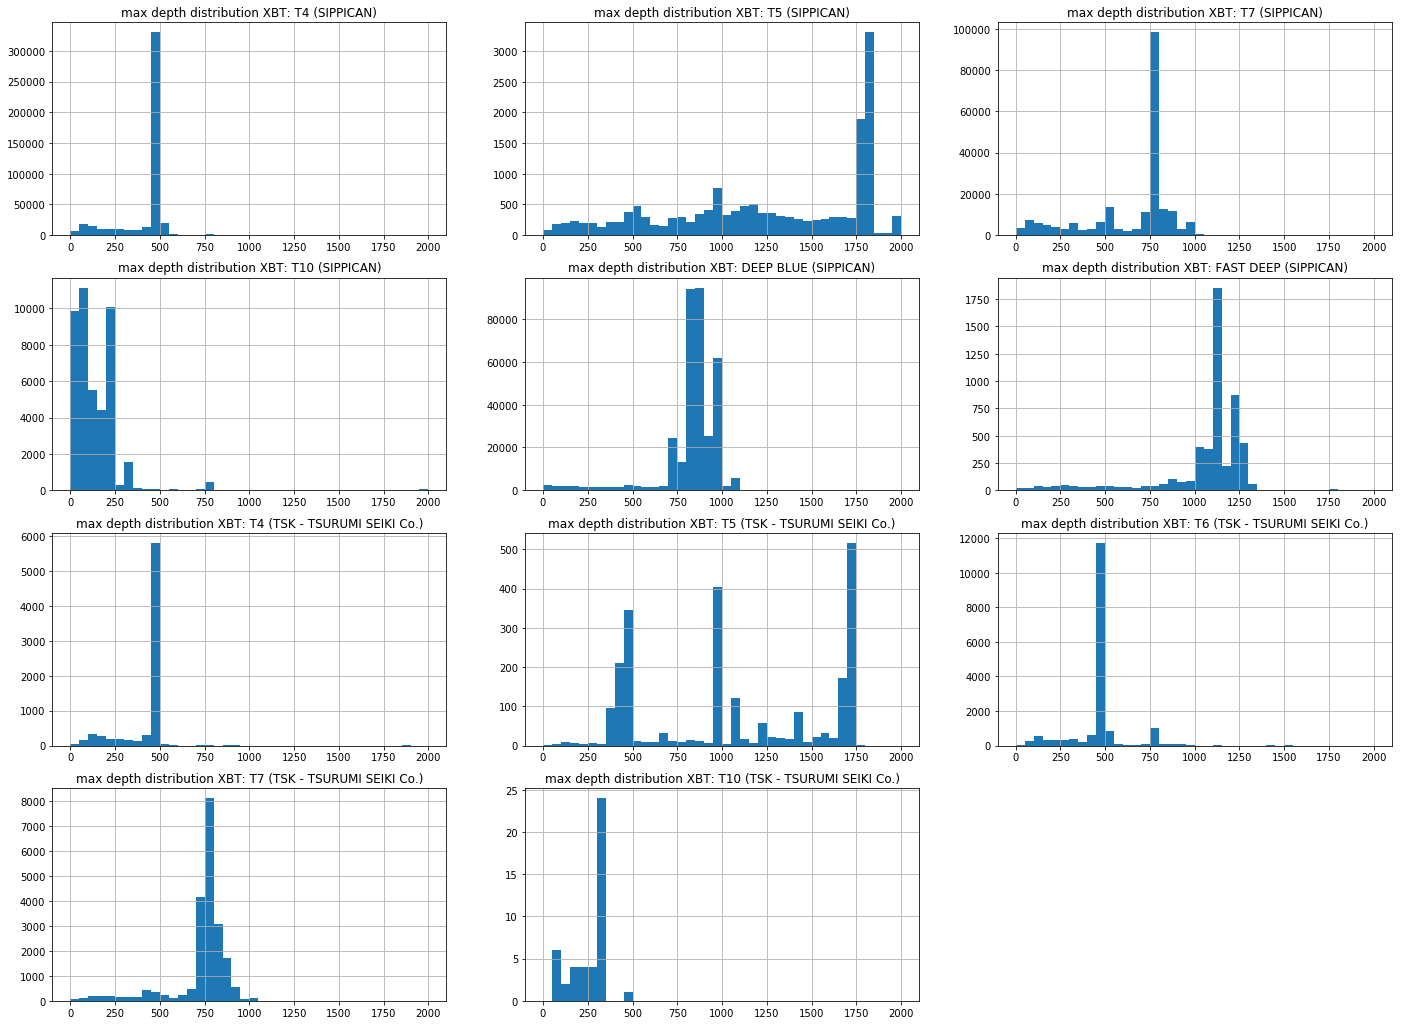

In [13]:
fig_probe_freq = matplotlib.pyplot.figure('probe frequency plot grid',figsize=(24,18))
for ix1, mfi in enumerate(instruments_to_plot):
    ax_depth_dist_type = fig_probe_freq.add_subplot(4,3,ix1+1,title=f'max depth distribution {mfi}')
    _ = xbt_labelled.filter_obs({'instrument': mfi})['max_depth'].hist(bins=depth_bins,ax=ax_depth_dist_type)


### Frequency of probe type by year
These plots show the frequency of different probe types by year of observation. This data was used to determine date thresholds in the iMeta algorithm.

In [14]:
plot_pairs = [ 
    ('XBT: T10 (SIPPICAN)', 'XBT: T4 (SIPPICAN)', lambda d1: d1<=360.0),
    ('XBT: T5 (SIPPICAN)', 'XBT: FAST DEEP (SIPPICAN)', lambda d1: d1>= 1000.0 and d1 <=1350.0),
    ('XBT: T7 (SIPPICAN)', 'XBT: DEEP BLUE (SIPPICAN)',lambda d1: d1>= 600.0 and d1 <=1000.0),
]

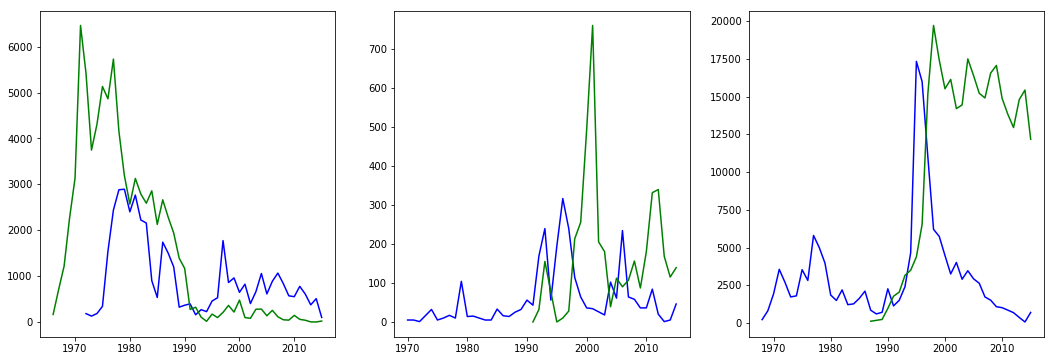

In [15]:
fig_freq_comp = matplotlib.pyplot.figure('plot types for year and max depth',figsize=(18,6))
l1 = []
for ix1, (type1, type2, filter1) in enumerate(plot_pairs):
    dataset_type1 = xbt_labelled.filter_obs({'instrument':type1}).xbt_df
    profiles_type1 = dataset_type1[dataset_type1.max_depth.apply(filter1)]
    dataset_type2 = xbt_labelled.filter_obs({'instrument':type2}).xbt_df
    profiles_type2 = dataset_type2[dataset_type2.max_depth.apply(filter1)]
    type_year_dist1 = profiles_type1.year.value_counts(sort=False)
    type_year_dist2 = profiles_type2.year.value_counts(sort=False)
    freq_df1 = pandas.DataFrame({'year': list(type_year_dist1.index), 'num_profiles': list(type_year_dist1.values)}).sort_values('year')
    freq_df2 = pandas.DataFrame({'year': list(type_year_dist2.index), 'num_profiles': list(type_year_dist2.values)}).sort_values('year')
    l1 += [(freq_df1, freq_df2)]
    ax1 = fig_freq_comp.add_subplot(130 + ix1 + 1)
    ax1.plot(list(freq_df1.year), list(freq_df1.num_profiles), color='b')
    ax1.plot(list(freq_df2.year), list(freq_df2.num_profiles), color='g')
    ax1.xmin=1950
    ax1.xmax=2020


## Number of correctly classified profiles
These plots show the number of profiles per year compared to the number of profiles with metadata, and what proportion of those profiles are correctly labelled (in terms of model and manufacturer) by the iMeta algorithm.


In [16]:
imeta_correct = [sum(actual_classes[xbt_labelled['year'] == year1] == imeta_classes[xbt_labelled['year'] == year1]) for year1 in range(DATA_YEAR_RANGE[0], DATA_YEAR_RANGE[1]+1)]

In [17]:
probe_type_correct = [sum(xbt_labelled['model'][xbt_labelled['year'] == year1] == imeta_model[xbt_labelled['year'] == year1]) for year1 in range(DATA_YEAR_RANGE[0], DATA_YEAR_RANGE[1]+1)]

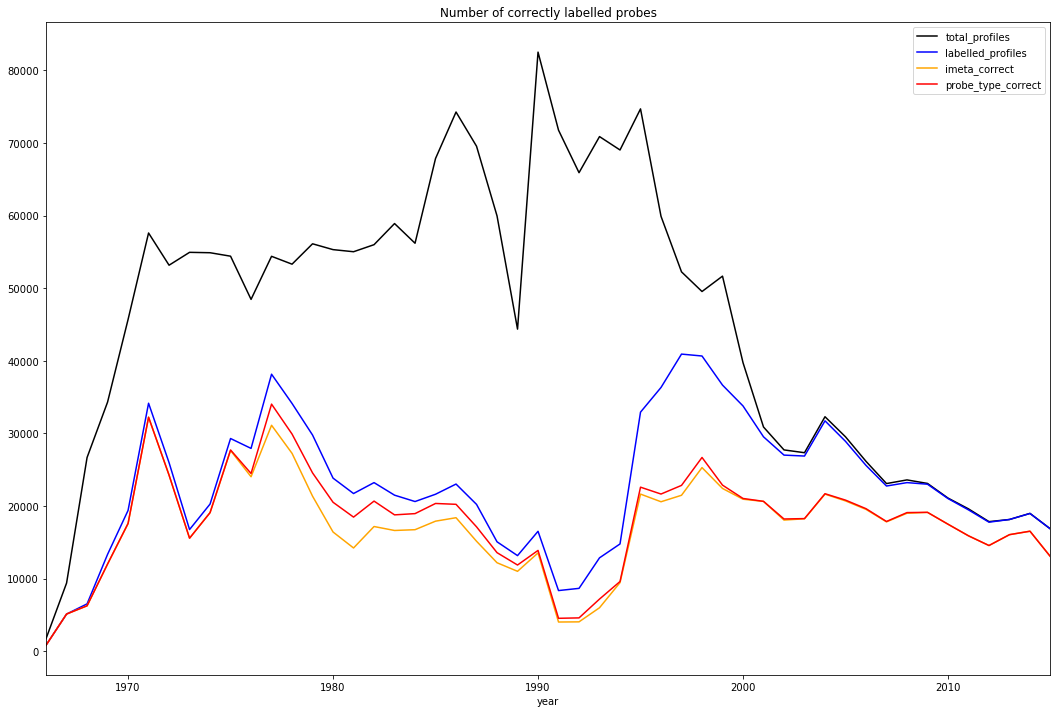

In [18]:
df_probe_labels = pandas.DataFrame.from_dict({
    'year': xbt_full_dataset['year'].value_counts(sort=False).index, 
    'total_profiles': xbt_full_dataset['year'].value_counts(sort=False).values,
    'labelled_profiles': xbt_labelled['year'].value_counts(sort=False).values,
    'imeta_correct': imeta_correct,
    'probe_type_correct': probe_type_correct, 
})
fig_probe_labels = matplotlib.pyplot.figure('correct_probe_labels')
ax_probe_labels = fig_probe_labels.add_subplot(111)
_ = df_probe_labels.plot(ax=ax_probe_labels, 
                     x='year',
                     y=['total_profiles','labelled_profiles','imeta_correct','probe_type_correct'],
                     figsize=(18,12),
                     title='Number of correctly labelled probes',
                     color=['k','b','orange','r'])
fig_probe_labels.savefig(os.path.join(result_dir, 'correct_probe_labels.png'))

### Accuracy of iMeta algorithm
The following plots analyse the accuracy of the iMeta algorithm. The metric used in the iMeta paper is recall. This is a measure of how many data points belonging to class A have been correctly classified as class A. The definition is (taken from [wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)
```
recall = (number of data points classified as class A that belong to class A) / (number of datapoints that belong to class A)
```

In [19]:

imeta_instrument = imeta_classes.apply(lambda t1: 'XBT: {0} ({1})'.format(*t1))

In [20]:
le1 = sklearn.preprocessing.LabelEncoder()
le1.fit(xbt_labelled['instrument'])


LabelEncoder()

In [21]:
actual_encoded = le1.transform(xbt_labelled['instrument'])
imeta_encoded = le1.transform(imeta_instrument)


In [22]:
(precision, recall, fscore, support
    ) = sklearn.metrics.precision_recall_fscore_support(actual_encoded, imeta_encoded)
metrics_df = pandas.DataFrame({'instrument': le1.classes_,
                               'precision': precision,
                               'recall': recall,
                               'f-score': fscore,
                               'support': support,
                              })


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
(precision_avg, recall_avg, fscore_avg, support_avg
    ) = sklearn.metrics.precision_recall_fscore_support(actual_encoded, imeta_encoded,average='micro')

In [24]:
print(f'average metrics for intelligent metadata algorithm on the labelled profiles: \n'
      f' precision: {precision_avg:.03f}\n'
      f' recall: {recall_avg:.03f}\n'
      f' f1 score: {fscore_avg:.03f}\n'
     )

average metrics for intelligent metadata algorithm on the labelled profiles: 
 precision: 0.753
 recall: 0.753
 f1 score: 0.753



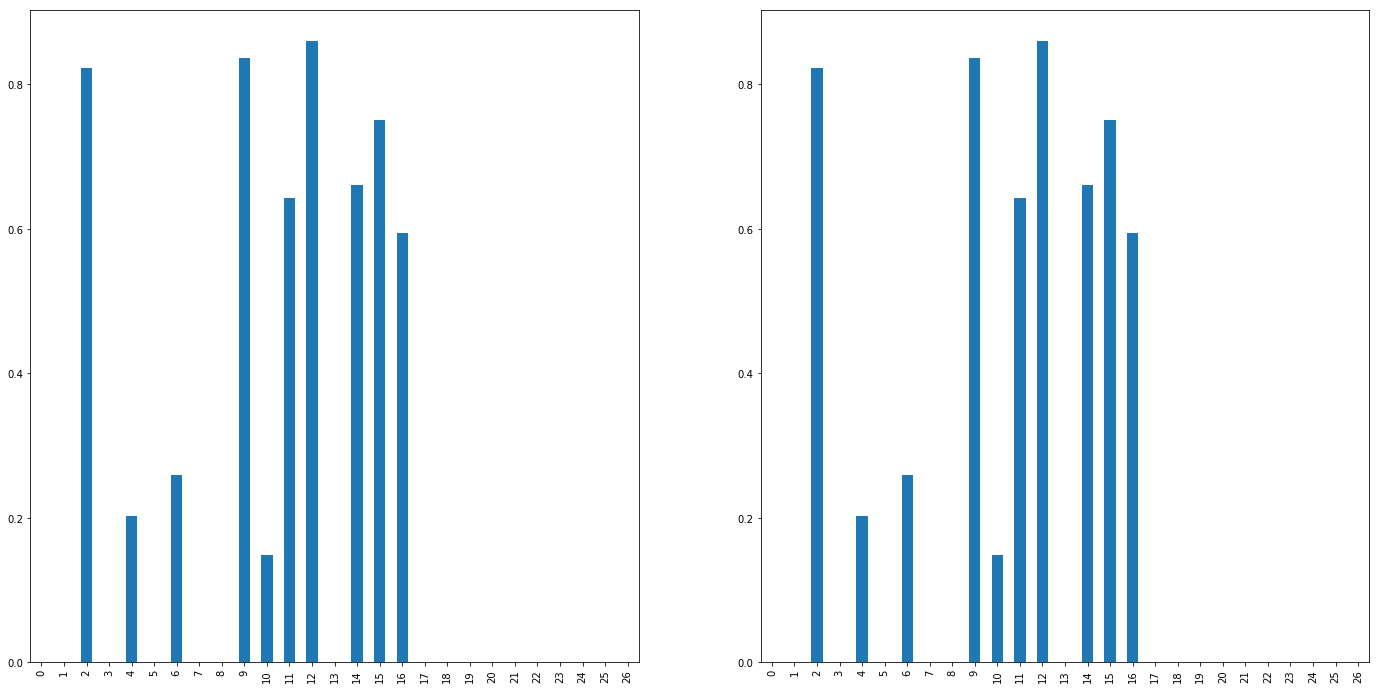

In [25]:
fig_imeta_scores = matplotlib.pyplot.figure('imeta scores', figsize=(24,12))
ax_precision = fig_imeta_scores.add_subplot(121)
metrics_df.precision.plot.bar(ax=ax_precision, x='instrument', y='precision')
ax_recall = fig_imeta_scores.add_subplot(122)
metrics_df.precision.plot.bar(ax=ax_recall, x='instrument', y='recall')

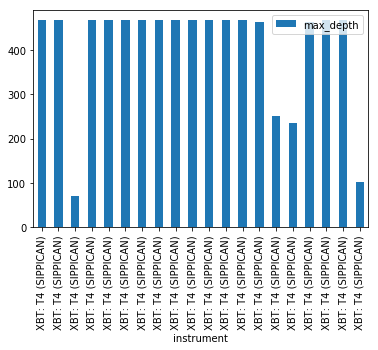

In [26]:
xbt_full_dataset.xbt_df[:20].plot.bar(x='instrument',y='max_depth')

### Probe model frequencies
These plots compare the distribution of probe model types for the profiles with model data compared with the assignments by the iMeta algorithm.

In [27]:
actual_labels = list(actual_classes.value_counts().keys())
actual_counts = actual_classes.value_counts().values
if len(actual_labels) > 10:
    actual_labels = actual_labels[:10] + ['other']
    actual_counts = list(actual_counts[:10]) + [sum(actual_counts[10:])]

In [28]:
imeta_labels = list(imeta_classes.value_counts().keys())
imeta_counts = list(imeta_classes.value_counts().values)

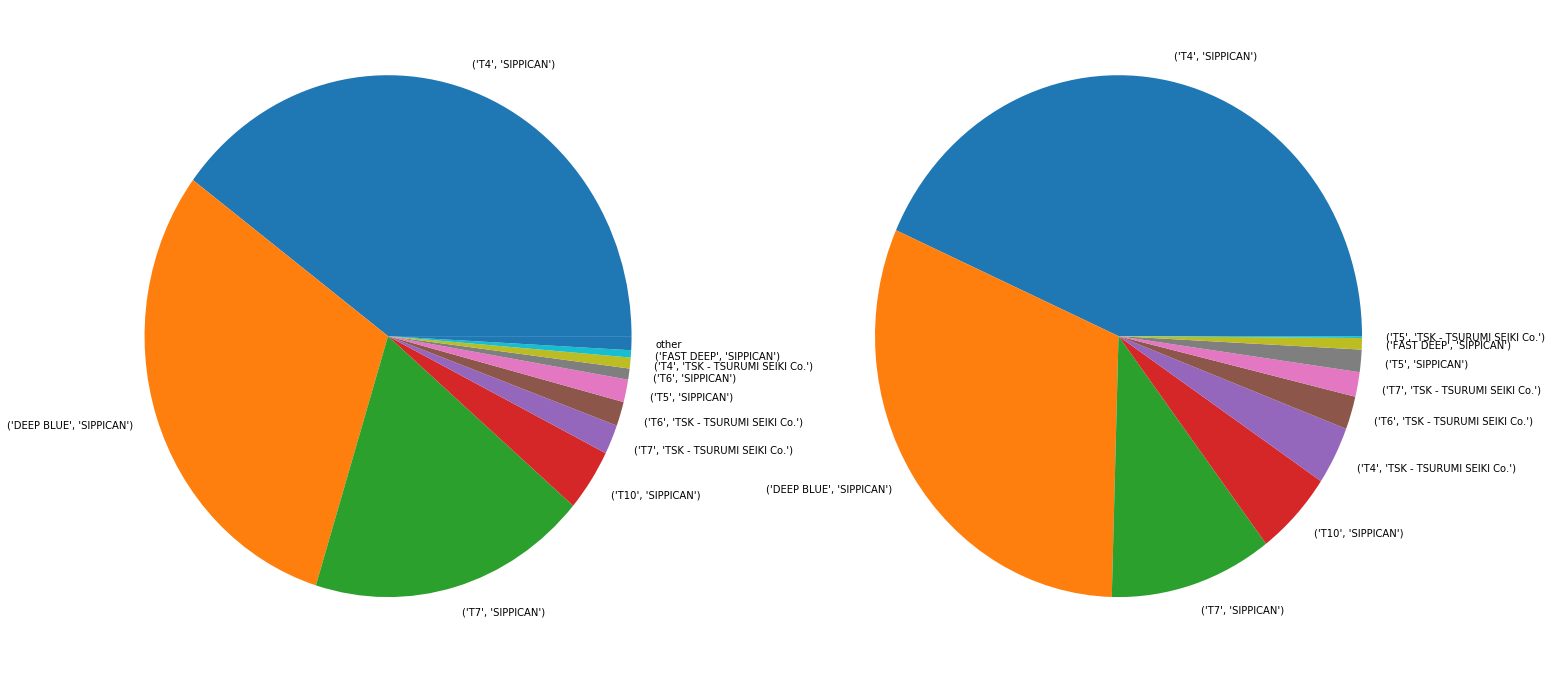

In [29]:
fig_name_probe_freqs = 'xbt probe type frequencies'
current_figure = matplotlib.pyplot.figure(fig_name_probe_freqs, figsize=(24,12))
axes_actual_types = current_figure.add_subplot(121)
actual_plot_objs = axes_actual_types.pie(actual_counts,labels=actual_labels)
axes_imeta_types = current_figure.add_subplot(122)
imeta_plot_objs = axes_imeta_types.pie(imeta_counts,labels=imeta_labels)
current_figure.savefig(os.path.join(result_dir, fig_name_probe_freqs + '.png'))

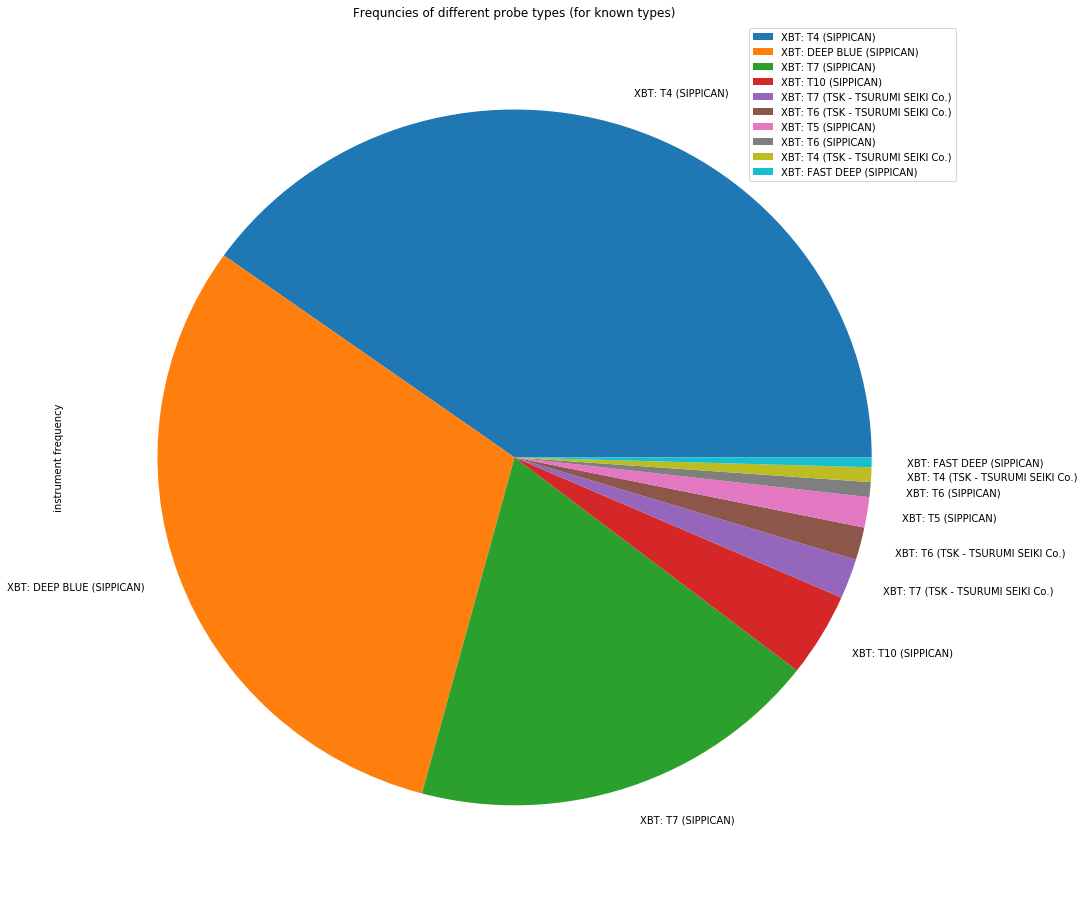

In [32]:
fig_instr_freq_pie = matplotlib.pyplot.figure('instrument_freqs', figsize=(16,16))
ax_instr_freq_pie = fig_instr_freq_pie.add_subplot(1,1,1, title='Frequncies of different probe types (for known types)')
_ = pandas.DataFrame({'instrument': xbt_labelled.xbt_df.instrument.value_counts().index[:10],
                  'instrument frequency': xbt_labelled.xbt_df.instrument.value_counts().values[:10],
                 },index=xbt_labelled.xbt_df.instrument.value_counts().index[:10]).plot.pie(ax=ax_instr_freq_pie, y='instrument frequency', figsize=(16,16))

### Probe types for different subsets of countries
next we want to see if there is going to be much predictability based on the country of origin, a feature used by imeta. We will look at how the instrument type frequewncies vary between the two sets of countries used in iMeta. The two groups are
* East Asian countries: China, Taiwan, Republic of Korea, Japan
* rest of the world

In [62]:
xbt_east_asia= xbt_labelled.xbt_df[(xbt_labelled.xbt_df.country =='JAPAN') | (xbt_labelled.xbt_df.country =='KOREA; REPUBLIC OF') | (xbt_labelled.xbt_df.country =='CHINA') | (xbt_labelled.xbt_df.country =='TAIWAN')]
xbt_rest_of_world = xbt_labelled.xbt_df[(xbt_labelled.xbt_df.country !='JAPAN') & (xbt_labelled.xbt_df.country !='KOREA; REPUBLIC OF') & (xbt_labelled.xbt_df.country !='CHINA') & (xbt_labelled.xbt_df.country !='TAIWAN')]

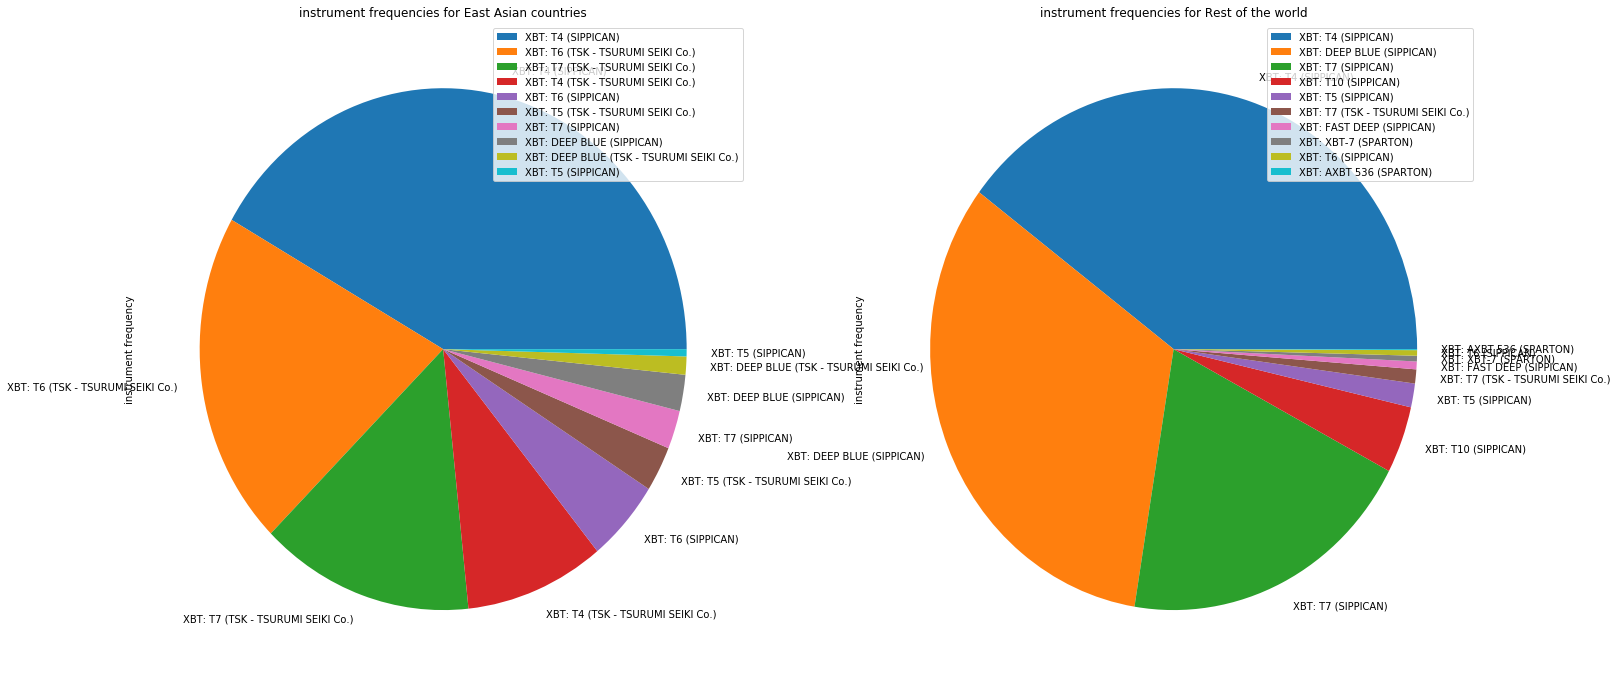

In [64]:
figure_type_freqs_by_country = matplotlib.pyplot.figure('xbt instrument types by country', figsize=(24,12))
ax_type_freqs_east_asia = figure_type_freqs_by_country.add_subplot(1,2,1,title='instrument frequencies for East Asian countries')
_ = pandas.DataFrame({'instrument': xbt_east_asia.instrument.value_counts().index[:10],
                  'instrument frequency': xbt_east_asia.instrument.value_counts().values[:10],
                 },index=xbt_east_asia.instrument.value_counts().index[:10]).plot.pie(ax=ax_type_freqs_east_asia, y='instrument frequency')
ax_type_freqs_rest_of_world = figure_type_freqs_by_country.add_subplot(1,2,2,title='instrument frequencies for Rest of the world')
_ = pandas.DataFrame({'instrument': xbt_rest_of_world.instrument.value_counts().index[:10],
                  'instrument frequency': xbt_rest_of_world.instrument.value_counts().values[:10],
                 },index=xbt_rest_of_world.instrument.value_counts().index[:10]).plot.pie(ax=ax_type_freqs_rest_of_world, y='instrument frequency')



The pie charts show the frequencies of different probe types for different sets of countries based on the division in the iMeta algorithm. T4 Sippican is the most frequent in both, but the plots also show that there is some predictability in the country of origin feature and so it should also be included as an input to the machine learning algorithm.

## Conclusions based on imeta analysis

We have further analysed the data and also the Intelligent Metadata approach in this notebook, and there are some further points to consider in the design of the machine learning piepleline:
* as composition varies by year, we should also ensure we split evenly by year i.e. we split profiles into train/test sets for each year separately, to ensure train and test contains example from each year
* `year` and `max_depth` both show predictability
* based on the results of the iMeta algorithm, we expect `country` (of origin) to be an input with good predictability of instrument, but we don't expect `latitude` and `longitude` to improve results much or if at all.
